<a href="https://colab.research.google.com/github/MinatoRyu007/CNN-Swin/blob/main/CNN_Swin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Load Google Cloud Drive

In [1]:
#!pip install tensorflow-addons
!pip install spectral
!pip install keras==2.4.3
!pip install tensorflow
!pip install plotly

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.9/212.9 kB 1.6 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
  Attempting uninstall: keras
    Found existing installation: keras 3.0.5
    Uninstalling keras-3.0.5:
      Successfully uninstalled keras-3.0.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
keras-nlp 0.8.2 requires keras-core, which is not installed.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 2.4.3 which is incompatible.

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 7.9 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: keras
    Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfu

# Setup

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
#import tensorflow_addons as tfa
import keras
from tensorflow import keras
from keras import layers
from keras.models import Model
from keras.layers import Dropout, Input, Conv2D, Conv3D, MaxPool3D, Flatten, Dense, Reshape, BatchNormalization
import spectral
import os
import scipy.io as sio
import seaborn as sns
import pandas as pd
import time
# from keras.utils import np_utils

from operator import truediv
## Ploting
from plotly.offline import init_notebook_mode
import plotly.graph_objs as go
from matplotlib.pyplot import cm
import matplotlib.pyplot as plt
init_notebook_mode(connected=True)
%matplotlib inline

## Deep Model
from plotly.offline import iplot, init_notebook_mode
from keras.losses import categorical_crossentropy
# from keras.optimizers import ad

from keras.models import Sequential, Model
# from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint

## Sklearn
import sklearn
from sklearn.decomposition import IncrementalPCA
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score




In [3]:
# keras.__version__
tf.__version__

'2.15.0'

## Data Preparation

In [4]:
# Apply PCA transform to hyperspectral data X
def applyPCA(X, numComponents):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0], X.shape[1], numComponents))
    return newX

# When extracting the patch around a single pixel, the edge pixels cannot be taken, so a padding operation is applied to this part of the pixel (margin original is 2)
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX


# Extract the patch around each pixel and create it in a format that matches the keras processing (originally windowSize=5)
def createImageCubes(X, y, windowSize=8, removeZeroLabels = True):
    # for X to padding
    margin = int((windowSize ) / 2)  # hybirdcnn是（（windowsize-1）/2）
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

def splitTrainTestSet(X, y, testRatio, randomState=345):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=randomState, stratify=y)
    return X_train, X_test, y_train, y_test


In [5]:
#loading dataset
X = sio.loadmat('/kaggle/input/dataset/dataset/PU/PaviaU.mat')['paviaU']
y = sio.loadmat('/kaggle/input/dataset/dataset/PU/PaviaU_gt.mat')['paviaU_gt']


dataset = '/kaggle/input/dataset'
# classes
num_classes = 9
# Proportion of the sample used for testing
test_ratio = 0.7
# Size of the extracted patch around each pixel
patch1_size = 25
# Number of principal components obtained by dimensionality reduction using PCA (original data: 30)
pca_components = 30

print('Hyperspectral data shape: ', X.shape)
print('Label shape: ', y.shape)

print('\n... ... PCA tranformation ... ...')
X_pca = applyPCA(X, numComponents=pca_components)
print('Data shape after PCA: ', X_pca.shape)


print('\n... ... create data cubes ... ...')
X_pca, y = createImageCubes(X_pca, y, windowSize=patch1_size)
print('Data cube X shape: ', X_pca.shape)
print('Data cube y shape: ', y.shape)

print('\n... ... create train & test data ... ...')
Xtrain, Xtest, ytrain, ytest = splitTrainTestSet(X_pca, y, test_ratio)
print('Xtrain shape: ', Xtrain.shape)
print('Xtest  shape: ', Xtest.shape)

# Change the shape of Xtrain, Ytrain to match keras
Xtrain = Xtrain.reshape(-1, patch1_size, patch1_size, pca_components, 1)
Xtest  = Xtest.reshape(-1, patch1_size, patch1_size, pca_components, 1)
ytrain = tf.keras.utils.to_categorical(ytrain)
#ytrain = keras.utils.to_categorical(ytrain, num_classes)
ytest = keras.utils.to_categorical(ytest, num_classes)
print('Xtrain shape: ', Xtrain.shape)
print('Xtest  shape: ', Xtest.shape)
print('ytrain shape: ',{ytrain.shape})
print('ytest shape:' , {ytest.shape})

Hyperspectral data shape:  (610, 340, 103)
Label shape:  (610, 340)

... ... PCA tranformation ... ...
Data shape after PCA:  (610, 340, 30)

... ... create data cubes ... ...
Data cube X shape:  (42776, 25, 25, 30)
Data cube y shape:  (42776,)

... ... create train & test data ... ...
Xtrain shape:  (12832, 25, 25, 30)
Xtest  shape:  (29944, 25, 25, 30)
Xtrain shape:  (12832, 25, 25, 30, 1)
Xtest  shape:  (29944, 25, 25, 30, 1)
ytrain shape:  {(12832, 9)}
ytest shape: {(29944, 9)}


# Parameters and Functions

In [6]:
input_shape = (25, 25, 30) #need to follow loading.shape and afterPCA

output_units = 9 #(hybrid is 9 )11

patch_size = (2, 2)  # 2-by-2 sized patches
dropout_rate = 0.03  # Dropout rate (origin0.03)
num_heads = 8  # Attention heads
embed_dim = 64  # Embedding dimension (origin64)
num_mlp = 256  # MLP layer size
qkv_bias = True  # Convert embedded patches to query, key, and values with a learnable additive value
window_size = 2  # Size of attention window
shift_size = 1  # Size of shifting window
image_dimension = 25  # Initial image size (origin32) （afterPCA25）（afterCNN module 17）

num_patch_x = input_shape[0] // patch_size[0]
num_patch_y = input_shape[1] // patch_size[1]

learning_rate = 1e-3
batch_size = 128
num_epochs = 10
validation_split = 0.1
weight_decay = 0.0001
label_smoothing = 0.1


## help function

In [7]:


def window_partition(x, window_size):
    _, height, width, channels = x.shape
    patch_num_y = height // window_size
    patch_num_x = width // window_size
    x = tf.reshape(
        x, shape=(-1, patch_num_y, window_size, patch_num_x, window_size, channels)
    )
    x = tf.transpose(x, (0, 1, 3, 2, 4, 5))
    windows = tf.reshape(x, shape=(-1, window_size, window_size, channels))
    return windows


def window_reverse(windows, window_size, height, width, channels):
    patch_num_y = height // window_size
    patch_num_x = width // window_size
    x = tf.reshape(
        windows,
        shape=(-1, patch_num_y, patch_num_x, window_size, window_size, channels),
    )
    x = tf.transpose(x, perm=(0, 1, 3, 2, 4, 5))
    x = tf.reshape(x, shape=(-1, height, width, channels))
    return x


class DropPath(layers.Layer):
    def __init__(self, drop_prob=None, **kwargs):
        super(DropPath, self).__init__(**kwargs)
        self.drop_prob = drop_prob

    def call(self, x):
        input_shape = tf.shape(x)
        batch_size = input_shape[0]
        rank = x.shape.rank
        shape = (batch_size,) + (1,) * (rank - 1)
        random_tensor = (1 - self.drop_prob) + tf.random.uniform(shape, dtype=x.dtype)
        path_mask = tf.floor(random_tensor)
        output = tf.math.divide(x, 1 - self.drop_prob) * path_mask
        return output


## Window based multi-head self-attention

In [8]:

class WindowAttention(layers.Layer):
    def __init__(
        self, dim, window_size, num_heads, qkv_bias=True, dropout_rate=0.0, **kwargs
    ):
        super(WindowAttention, self).__init__(**kwargs)
        self.dim = dim
        self.window_size = window_size
        self.num_heads = num_heads
        self.scale = (dim // num_heads) ** -0.5
        self.qkv = layers.Dense(dim * 3, use_bias=qkv_bias)
        self.dropout = layers.Dropout(dropout_rate)
        self.proj = layers.Dense(dim)

    def build(self, input_shape):
        num_window_elements = (2 * self.window_size[0] - 1) * (
            2 * self.window_size[1] - 1
        )
        self.relative_position_bias_table = self.add_weight(
            shape=(num_window_elements, self.num_heads),
            initializer=tf.initializers.Zeros(),
            trainable=True,
        )
        coords_h = np.arange(self.window_size[0])
        coords_w = np.arange(self.window_size[1])
        coords_matrix = np.meshgrid(coords_h, coords_w, indexing="ij")
        coords = np.stack(coords_matrix)
        coords_flatten = coords.reshape(2, -1)
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]
        relative_coords = relative_coords.transpose([1, 2, 0])
        relative_coords[:, :, 0] += self.window_size[0] - 1
        relative_coords[:, :, 1] += self.window_size[1] - 1
        relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1
        relative_position_index = relative_coords.sum(-1)

        self.relative_position_index = tf.Variable(
            initial_value=tf.convert_to_tensor(relative_position_index), trainable=False
        )

    def call(self, x, mask=None):
        _, size, channels = x.shape
        head_dim = channels // self.num_heads
        x_qkv = self.qkv(x)
        x_qkv = tf.reshape(x_qkv, shape=(-1, size, 3, self.num_heads, head_dim))
        x_qkv = tf.transpose(x_qkv, perm=(2, 0, 3, 1, 4))
        q, k, v = x_qkv[0], x_qkv[1], x_qkv[2]
        q = q * self.scale
        k = tf.transpose(k, perm=(0, 1, 3, 2))
        attn = q @ k

        num_window_elements = self.window_size[0] * self.window_size[1]
        relative_position_index_flat = tf.reshape(
            self.relative_position_index, shape=(-1,)
        )
        relative_position_bias = tf.gather(
            self.relative_position_bias_table, relative_position_index_flat
        )
        relative_position_bias = tf.reshape(
            relative_position_bias, shape=(num_window_elements, num_window_elements, -1)
        )
        relative_position_bias = tf.transpose(relative_position_bias, perm=(2, 0, 1))
        attn = attn + tf.expand_dims(relative_position_bias, axis=0)

        if mask is not None:
            nW = mask.get_shape()[0]
            mask_float = tf.cast(
                tf.expand_dims(tf.expand_dims(mask, axis=1), axis=0), tf.float32
            )
            attn = (
                tf.reshape(attn, shape=(-1, nW, self.num_heads, size, size))
                + mask_float
            )
            attn = tf.reshape(attn, shape=(-1, self.num_heads, size, size))
            attn = keras.activations.softmax(attn, axis=-1)
        else:
            attn = keras.activations.softmax(attn, axis=-1)
        attn = self.dropout(attn)

        x_qkv = attn @ v
        x_qkv = tf.transpose(x_qkv, perm=(0, 2, 1, 3))
        x_qkv = tf.reshape(x_qkv, shape=(-1, size, channels))
        x_qkv = self.proj(x_qkv)
        x_qkv = self.dropout(x_qkv)
        return x_qkv


# Swin Transformer model

In [9]:

class SwinTransformer(layers.Layer):
    def __init__(
        self,
        dim,
        num_patch,
        num_heads,
        window_size=7,
        shift_size=0,
        num_mlp=1024,
        qkv_bias=True,
        dropout_rate=0.0,
        **kwargs,
    ):
        super(SwinTransformer, self).__init__(**kwargs)

        self.dim = dim  # number of input dimensions
        self.num_patch = num_patch  # number of embedded patches
        self.num_heads = num_heads  # number of attention heads
        self.window_size = window_size  # size of window
        self.shift_size = shift_size  # size of window shift
        self.num_mlp = num_mlp  # number of MLP nodes

        self.norm1 = layers.LayerNormalization(epsilon=1e-5)
        self.attn = WindowAttention(
            dim,
            window_size=(self.window_size, self.window_size),
            num_heads=num_heads,
            qkv_bias=qkv_bias,
            dropout_rate=dropout_rate,
        )
        self.drop_path = DropPath(dropout_rate)
        self.norm2 = layers.LayerNormalization(epsilon=1e-5)

        self.mlp = keras.Sequential(
            [
                layers.Dense(num_mlp),
                layers.Activation(keras.activations.gelu),
                layers.Dropout(dropout_rate),
                layers.Dense(dim),
                layers.Dropout(dropout_rate),
            ]
        )

        if min(self.num_patch) < self.window_size:
            self.shift_size = 0
            self.window_size = min(self.num_patch)

    def build(self, input_shape):
        if self.shift_size == 0:
            self.attn_mask = None
        else:
            height, width = self.num_patch
            h_slices = (
                slice(0, -self.window_size),
                slice(-self.window_size, -self.shift_size),
                slice(-self.shift_size, None),
            )
            w_slices = (
                slice(0, -self.window_size),
                slice(-self.window_size, -self.shift_size),
                slice(-self.shift_size, None),
            )
            mask_array = np.zeros((1, height, width, 1))
            count = 0
            for h in h_slices:
                for w in w_slices:
                    mask_array[:, h, w, :] = count
                    count += 1
            mask_array = tf.convert_to_tensor(mask_array)

            # mask array to windows
            mask_windows = window_partition(mask_array, self.window_size)
            mask_windows = tf.reshape(
                mask_windows, shape=[-1, self.window_size * self.window_size]
            )
            attn_mask = tf.expand_dims(mask_windows, axis=1) - tf.expand_dims(
                mask_windows, axis=2
            )
            attn_mask = tf.where(attn_mask != 0, -100.0, attn_mask)
            attn_mask = tf.where(attn_mask == 0, 0.0, attn_mask)
            self.attn_mask = tf.Variable(initial_value=attn_mask, trainable=False)

    def call(self, x):
        height, width = self.num_patch
        _, num_patches_before, channels = x.shape
        x_skip = x
        x = self.norm1(x)
        x = tf.reshape(x, shape=(-1, height, width, channels))
        if self.shift_size > 0:
            shifted_x = tf.roll(
                x, shift=[-self.shift_size, -self.shift_size], axis=[1, 2]
            )
        else:
            shifted_x = x

        x_windows = window_partition(shifted_x, self.window_size)
        x_windows = tf.reshape(
            x_windows, shape=(-1, self.window_size * self.window_size, channels)
        )
        attn_windows = self.attn(x_windows, mask=self.attn_mask)

        attn_windows = tf.reshape(
            attn_windows, shape=(-1, self.window_size, self.window_size, channels)
        )
        shifted_x = window_reverse(
            attn_windows, self.window_size, height, width, channels
        )
        if self.shift_size > 0:
            x = tf.roll(
                shifted_x, shift=[self.shift_size, self.shift_size], axis=[1, 2]
            )
        else:
            x = shifted_x

        x = tf.reshape(x, shape=(-1, height * width, channels))
        x = self.drop_path(x)
        x = x_skip + x
        x_skip = x
        x = self.norm2(x)
        x = self.mlp(x)
        x = self.drop_path(x)
        x = x_skip + x
        return x


# Modeling and Training

Three layers were created to help us extract, embed and merge patches from the image, on top of which we will use the Swin Transformer class we created.

## preparation

In [10]:

class PatchExtract(layers.Layer):
    def __init__(self, patch_size, **kwargs):
        super(PatchExtract, self).__init__(**kwargs)
        self.patch_size_x = patch_size[0]
        self.patch_size_y = patch_size[0]

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=(1, self.patch_size_x, self.patch_size_y, 1),
            strides=(1, self.patch_size_x, self.patch_size_y, 1),
            rates=(1, 1, 1, 1),
            padding="VALID",
        )
        patch_dim = patches.shape[-1]
        patch_num = patches.shape[1]
        return tf.reshape(patches, (batch_size, patch_num * patch_num, patch_dim))


class PatchEmbedding(layers.Layer):
    def __init__(self, num_patch, embed_dim, **kwargs):
        super(PatchEmbedding, self).__init__(**kwargs)
        self.num_patch = num_patch
        self.proj = layers.Dense(embed_dim)
        self.pos_embed = layers.Embedding(input_dim=num_patch, output_dim=embed_dim)

    def call(self, patch):
        pos = tf.range(start=0, limit=self.num_patch, delta=1)
        return self.proj(patch) + self.pos_embed(pos)


class PatchMerging(tf.keras.layers.Layer):
    def __init__(self, num_patch, embed_dim):
        super(PatchMerging, self).__init__()
        self.num_patch = num_patch
        self.embed_dim = embed_dim
        self.linear_trans = layers.Dense(2 * embed_dim, use_bias=False)

    def call(self, x):
        height, width = self.num_patch
        _, _, C = x.get_shape().as_list()
        x = tf.reshape(x, shape=(-1, height, width, C))
        x0 = x[:, 0::2, 0::2, :]
        x1 = x[:, 1::2, 0::2, :]
        x2 = x[:, 0::2, 1::2, :]
        x3 = x[:, 1::2, 1::2, :]
        x = tf.concat((x0, x1, x2, x3), axis=-1)
        x = tf.reshape(x, shape=(-1, (height // 2) * (width // 2), 4 * C))
        return self.linear_trans(x)


## Modeling

CNN model

In [11]:
input = layers.Input((25, 25, 30, 1))
## 3D Convolutional Layers
## convolutional layers
conv_layer1 = Conv3D(filters=8, kernel_size=(3, 3, 7), activation='relu')(input)
conv_layer2 = Conv3D(filters=16, kernel_size=(3, 3, 5), activation='relu')(conv_layer1)
conv_layer3 = Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu')(conv_layer2)
print(conv_layer3.shape)
conv3d_shape = conv_layer3.shape
conv_layer3 = Reshape((conv3d_shape[1], conv3d_shape[2], conv3d_shape[3]*conv3d_shape[4]))(conv_layer3)
## 2d CNN
conv_layer4 = Conv2D(filters=64, kernel_size=(3,3), activation='relu')(conv_layer3)
print(conv_layer4.shape)



2024-03-31 09:29:17.643226: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-03-31 09:29:17.643332: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-03-31 09:29:17.643411: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-03-31 09:29:17.643498: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-03-31 09:29:17.643591: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-03-31 09:29:17.643776: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-03-31 09:29:17.643871: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this 

(None, 19, 19, 18, 32)
(None, 17, 17, 64)


swin model


In [12]:

#input = layers.Input(input_shape)
#print('input:',input.shape)
x = layers.RandomCrop(image_dimension, image_dimension)(conv_layer4)
print('random crop:',x.shape)
x = layers.RandomFlip("horizontal")(x)
print('random flip:',x.shape)
x = PatchExtract(patch_size)(x)
print('patch extract:',x.shape)
x = PatchEmbedding(num_patch_x * num_patch_y, embed_dim)(x)
print('patch embedding:',x.shape)
x = SwinTransformer(
    dim=embed_dim,
    num_patch=(num_patch_x, num_patch_y),
    num_heads=num_heads,
    window_size=window_size,
    shift_size=0,
    num_mlp=num_mlp,
    qkv_bias=qkv_bias,
    dropout_rate=dropout_rate,
)(x)
print('swin1:',x.shape)
x = SwinTransformer(
    dim=embed_dim,
    num_patch=(num_patch_x, num_patch_y),
    num_heads=num_heads,
    window_size=window_size,
    shift_size=shift_size,
    num_mlp=num_mlp,
    qkv_bias=qkv_bias,
    dropout_rate=dropout_rate,
)(x)
print('swin2:',x.shape)
x = PatchMerging((num_patch_x, num_patch_y), embed_dim=embed_dim)(x)
print('patchmerging:',x.shape)
x = layers.GlobalAveragePooling1D()(x)
print('global average pooling:',x.shape)
output = layers.Dense(num_classes, activation="softmax")(x)
print('out:',x.shape)

random crop: (None, 25, 25, 64)
random flip: (None, 25, 25, 64)
patch extract: (None, 144, 256)
patch embedding: (None, 144, 64)
swin1: (None, 144, 64)
swin2: (None, 144, 64)
patchmerging: (None, 36, 128)
global average pooling: (None, 128)
out: (None, 128)


## Train

In [13]:
model = keras.Model(input, output)
model.compile(
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=label_smoothing),
    optimizer=tf.keras.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    ),
    metrics=[
        keras.metrics.CategoricalAccuracy(name="accuracy"),
        keras.metrics.TopKCategoricalAccuracy(5, name="top-5-accuracy"),
    ],
)

history = model.fit(
    Xtrain, #The display is modified: the original indicates x_train, y_train
    ytrain, #
    batch_size=batch_size,
    epochs=num_epochs,
    validation_split=validation_split,
)

Epoch 1/10
91/91 [==============================] - 124s 1s/step - loss: 1.3115 - accuracy: 0.7013 - top-5-accuracy: 0.9301 - val_loss: 0.7229 - val_accuracy: 0.9213 - val_top-5-accuracy: 0.9992
Epoch 2/10
91/91 [==============================] - 115s 1s/step - loss: 0.6290 - accuracy: 0.9610 - top-5-accuracy: 0.9995 - val_loss: 0.5648 - val_accuracy: 0.9899 - val_top-5-accuracy: 0.9992
Epoch 3/10
91/91 [==============================] - 115s 1s/step - loss: 0.5544 - accuracy: 0.9877 - top-5-accuracy: 0.9998 - val_loss: 0.5369 - val_accuracy: 0.9922 - val_top-5-accuracy: 0.9992
Epoch 4/10
91/91 [==============================] - 115s 1s/step - loss: 0.5272 - accuracy: 0.9943 - top-5-accuracy: 0.9999 - val_loss: 0.5153 - val_accuracy: 0.9969 - val_top-5-accuracy: 1.0000
Epoch 5/10
91/91 [==============================] - 115s 1s/step - loss: 0.5148 - accuracy: 0.9959 - top-5-accuracy: 0.9998 - val_loss: 0.5225 - val_accuracy: 0.9977 - val_top-5-accuracy: 0.9992
Epoch 6/10
91/91 [=======

## Result

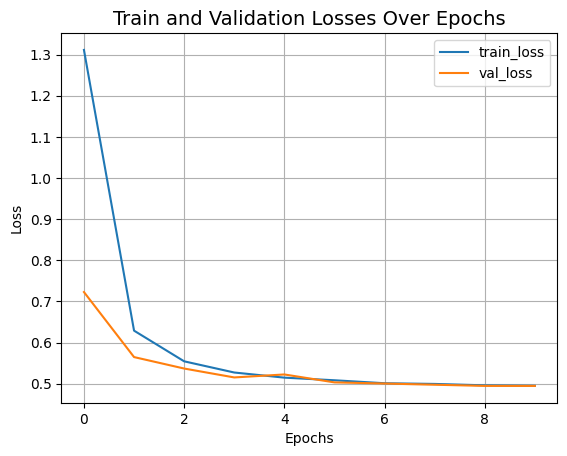

In [14]:
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Losses Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()


In [15]:

loss, accuracy, top_5_accuracy = model.evaluate(Xtest, ytest)
print(f"Test loss: {round(loss, 2)}")
print(f"Test accuracy: {round(accuracy * 100, 2)}%")
print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

936/936 [==============================] - 52s 56ms/step - loss: 0.4945 - accuracy: 0.9993 - top-5-accuracy: 1.0000
Test loss: 0.49
Test accuracy: 99.93%
Test top 5 accuracy: 100.0%


In [16]:
# define the model with input layer and output layer
model = Model(input, output)

In [17]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 25, 25, 30, 1)]   0         
                                                                 
 conv3d (Conv3D)             (None, 23, 23, 24, 8)     512       
                                                                 
 conv3d_1 (Conv3D)           (None, 21, 21, 20, 16)    5776      
                                                                 
 conv3d_2 (Conv3D)           (None, 19, 19, 18, 32)    13856     
                                                                 
 reshape (Reshape)           (None, 19, 19, 576)       0         
                                                                 
 conv2d (Conv2D)             (None, 17, 17, 64)        331840    
                                                                 
 random_crop (RandomCrop)    (None, 25, 25, 64)        0   

In [18]:
# load best weights
#model.load_weights("best-model.hdf5")
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [19]:
Xtest = Xtest.reshape(-1, 25, 25, 30, 1)
Xtest.shape


(29944, 25, 25, 30, 1)

In [20]:
# ytest = np_utils.to_categorical(ytest)
ytest.shape

(29944, 9)

In [21]:
Y_pred_test = model.predict(Xtest)
y_pred_test = np.argmax(Y_pred_test, axis=1)

classification = classification_report(np.argmax(ytest, axis=1), y_pred_test)
print(classification)

936/936 [==============================] - 54s 56ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4642
           1       1.00      1.00      1.00     13055
           2       1.00      1.00      1.00      1469
           3       1.00      0.99      1.00      2145
           4       1.00      1.00      1.00       942
           5       1.00      1.00      1.00      3520
           6       1.00      1.00      1.00       931
           7       1.00      1.00      1.00      2577
           8       1.00      0.99      1.00       663

    accuracy                           1.00     29944
   macro avg       1.00      1.00      1.00     29944
weighted avg       1.00      1.00      1.00     29944



In [22]:
def AA_andEachClassAccuracy(confusion_matrix):
    counter = confusion_matrix.shape[0]
    list_diag = np.diag(confusion_matrix)
    list_raw_sum = np.sum(confusion_matrix, axis=1)
    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
    average_acc = np.mean(each_acc)
    return each_acc, average_acc

In [23]:
def reports (X_test,y_test,name):
    #start = time.time()
    Y_pred = model.predict(X_test)
    y_pred = np.argmax(Y_pred, axis=1)
    #end = time.time()
    #print(end - start)
    if name == 'IP':
        target_names = ['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn'
                        ,'Grass-pasture', 'Grass-trees', 'Grass-pasture-mowed',
                        'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill',
                        'Soybean-clean', 'Wheat', 'Woods', 'Buildings-Grass-Trees-Drives',
                        'Stone-Steel-Towers']
    elif name == 'Salinas':
        target_names = ['Brocoli_green_weeds_1','Brocoli_green_weeds_2','Fallow','Fallow_rough_plow','Fallow_smooth',
                        'Stubble','Celery','Grapes_untrained','Soil_vinyard_develop','Corn_senesced_green_weeds',
                        'Lettuce_romaine_4wk','Lettuce_romaine_5wk','Lettuce_romaine_6wk','Lettuce_romaine_7wk',
                        'Vinyard_untrained','Vinyard_vertical_trellis']
    elif name == 'PU':
        target_names = ['Asphalt','Meadows','Gravel','Trees', 'Painted metal sheets','Bare Soil','Bitumen',
                        'Self-Blocking Bricks','Shadows']

    classification = classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names)
    oa = accuracy_score(np.argmax(y_test, axis=1), y_pred)
    confusion = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
    each_acc, aa = AA_andEachClassAccuracy(confusion)
    kappa = cohen_kappa_score(np.argmax(y_test, axis=1), y_pred)
    score = model.evaluate(X_test, y_test, batch_size=32)
    Test_Loss =  score[0]*100
    Test_accuracy = score[1]*100

    return classification, confusion, Test_Loss, Test_accuracy, oa*100, each_acc*100, aa*100, kappa*100

In [ ]:
# classification, confusion, Test_loss, Test_accuracy, oa, each_acc, aa, kappa = reports(Xtest,ytest,dataset)
# classification = str(classification)
# confusion = str(confusion)
# file_name = "classification_report.txt"

# with open(file_name, 'w') as x_file:
#     x_file.write('{} Test loss (%)'.format(Test_loss))
#     x_file.write('\n')
#     x_file.write('{} Test accuracy (%)'.format(Test_accuracy))
#     x_file.write('\n')
#     x_file.write('\n')
#     x_file.write('{} Kappa accuracy (%)'.format(kappa))
#     x_file.write('\n')
#     x_file.write('{} Overall accuracy (%)'.format(oa))
#     x_file.write('\n')
#     x_file.write('{} Average accuracy (%)'.format(aa))
#     x_file.write('\n')
#     x_file.write('\n')
#     x_file.write('{}'.format(classification))
#     x_file.write('\n')
#     x_file.write('{}'.format(confusion))

/tmp/ipykernel_13/3052353458.py:15: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

findfont: Font family 'Lato Light' not found.
findfont: Font family 'Lato Light' not found.
findfont: Font family 'Lato Light' not found.
findfont: Font family 'Lato Light' not found.
findfont: Font family 'Lato Light' not found.
findfont: Font family 'Lato Light' not found.
findfont: Font family 'Lato Light' not found.
findfont: Font family 'Lato Light' not found.
findfont: Font family 'Lato Light' not found.
findfont: Font family 'Lato Light' not found.
findfont: Font family 'Lato Light' not found.
findfont: Font family 'Lato Light' not found.
findfont: Font family 'Lato Light' not found.


<Axes: xlabel='Predicted', ylabel='Actual'>

findfont: Font family 'Lato Light' not found.
findfont: Font family 'Lato Light' not found.
findfont: Font family 'Lato Light' not found.
findfont: Font family 'Lato Light' not found.
findfont: Font family 'Lato Light' not found.
findfont: Font family 'Lato Light' not found.
findfont: Font family 'Lato Light' not found.
findfont: Font family 'Lato Light' not found.
findfont: Font family 'Lato Light' not found.
findfont: Font family 'Lato Light' not found.
findfont: Font family 'Lato Light' not found.
findfont: Font family 'Lato Light' not found.
findfont: Font family 'Lato Light' not found.
findfont: Font family 'Lato Light' not found.
findfont: Font family 'Lato Light' not found.
findfont: Font family 'Lato Light' not found.
findfont: Font family 'Lato Light' not found.
findfont: Font family 'Lato Light' not found.
findfont: Font family 'Lato Light' not found.
findfont: Font family 'Lato Light' not found.
findfont: Font family 'Lato Light' not found.
findfont: Font family 'Lato Light'

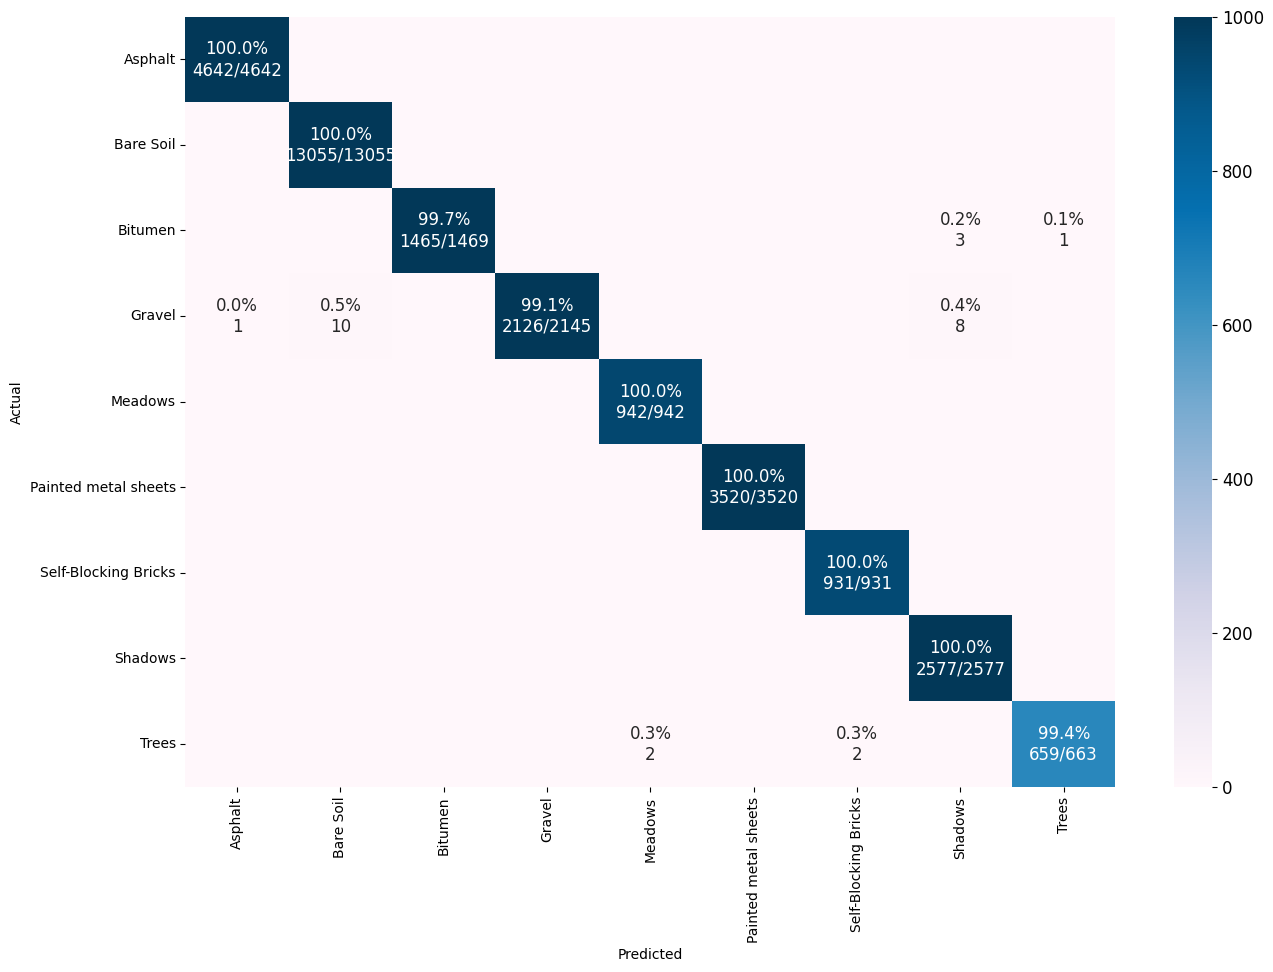

In [24]:
target_names =['Asphalt','Meadows','Gravel','Trees', 'Painted metal sheets','Bare Soil','Bitumen',
                        'Self-Blocking Bricks','Shadows'] 
 #cm
confusion = confusion_matrix(np.argmax(ytest, axis=1), y_pred_test, labels=np.unique(np.argmax(ytest, axis=1)))
cm_sum = np.sum(confusion, axis=1, keepdims=True)
cm_perc = confusion / cm_sum.astype(float) * 100
annot = np.empty_like(confusion).astype(str)
nrows, ncols = confusion.shape
for i in range(nrows):
    for j in range(ncols):
        c = confusion[i, j]
        p = cm_perc[i, j]
        if i == j:
            s = cm_sum[i]
            annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
        elif c == 0:
            annot[i, j] = ''
        else:
            annot[i, j] = '%.1f%%\n%d' % (p, c)


cm = pd.DataFrame(confusion, index=np.unique(target_names), columns=np.unique(target_names))
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
fig, ax = plt.subplots(figsize=(15,10))
#plt.rcParams.update({'font.size': 12})
plt.rc('font',family='Lato Light',size=12)

sns.heatmap(cm, cmap="PuBu", annot=annot, fmt='',vmax=1000, vmin=0, ax=ax)

/tmp/ipykernel_13/409519130.py:15: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

findfont: Font family 'Lato Light' not found.
findfont: Font family 'Lato Light' not found.
findfont: Font family 'Lato Light' not found.
findfont: Font family 'Lato Light' not found.
findfont: Font family 'Lato Light' not found.
findfont: Font family 'Lato Light' not found.
findfont: Font family 'Lato Light' not found.
findfont: Font family 'Lato Light' not found.
findfont: Font family 'Lato Light' not found.
findfont: Font family 'Lato Light' not found.
findfont: Font family 'Lato Light' not found.
findfont: Font family 'Lato Light' not found.
findfont: Font family 'Lato Light' not found.
findfont: Font family 'Lato Light' not found.
findfont: Font family 'Lato Light' not found.
findfont: Font family 'Lato Light' not found.
findfo

<Axes: xlabel='Predicted', ylabel='Actual'>

findfont: Font family 'Lato Light' not found.
findfont: Font family 'Lato Light' not found.
findfont: Font family 'Lato Light' not found.
findfont: Font family 'Lato Light' not found.
findfont: Font family 'Lato Light' not found.
findfont: Font family 'Lato Light' not found.
findfont: Font family 'Lato Light' not found.
findfont: Font family 'Lato Light' not found.
findfont: Font family 'Lato Light' not found.
findfont: Font family 'Lato Light' not found.
findfont: Font family 'Lato Light' not found.
findfont: Font family 'Lato Light' not found.
findfont: Font family 'Lato Light' not found.
findfont: Font family 'Lato Light' not found.
findfont: Font family 'Lato Light' not found.
findfont: Font family 'Lato Light' not found.
findfont: Font family 'Lato Light' not found.
findfont: Font family 'Lato Light' not found.
findfont: Font family 'Lato Light' not found.
findfont: Font family 'Lato Light' not found.
findfont: Font family 'Lato Light' not found.
findfont: Font family 'Lato Light'

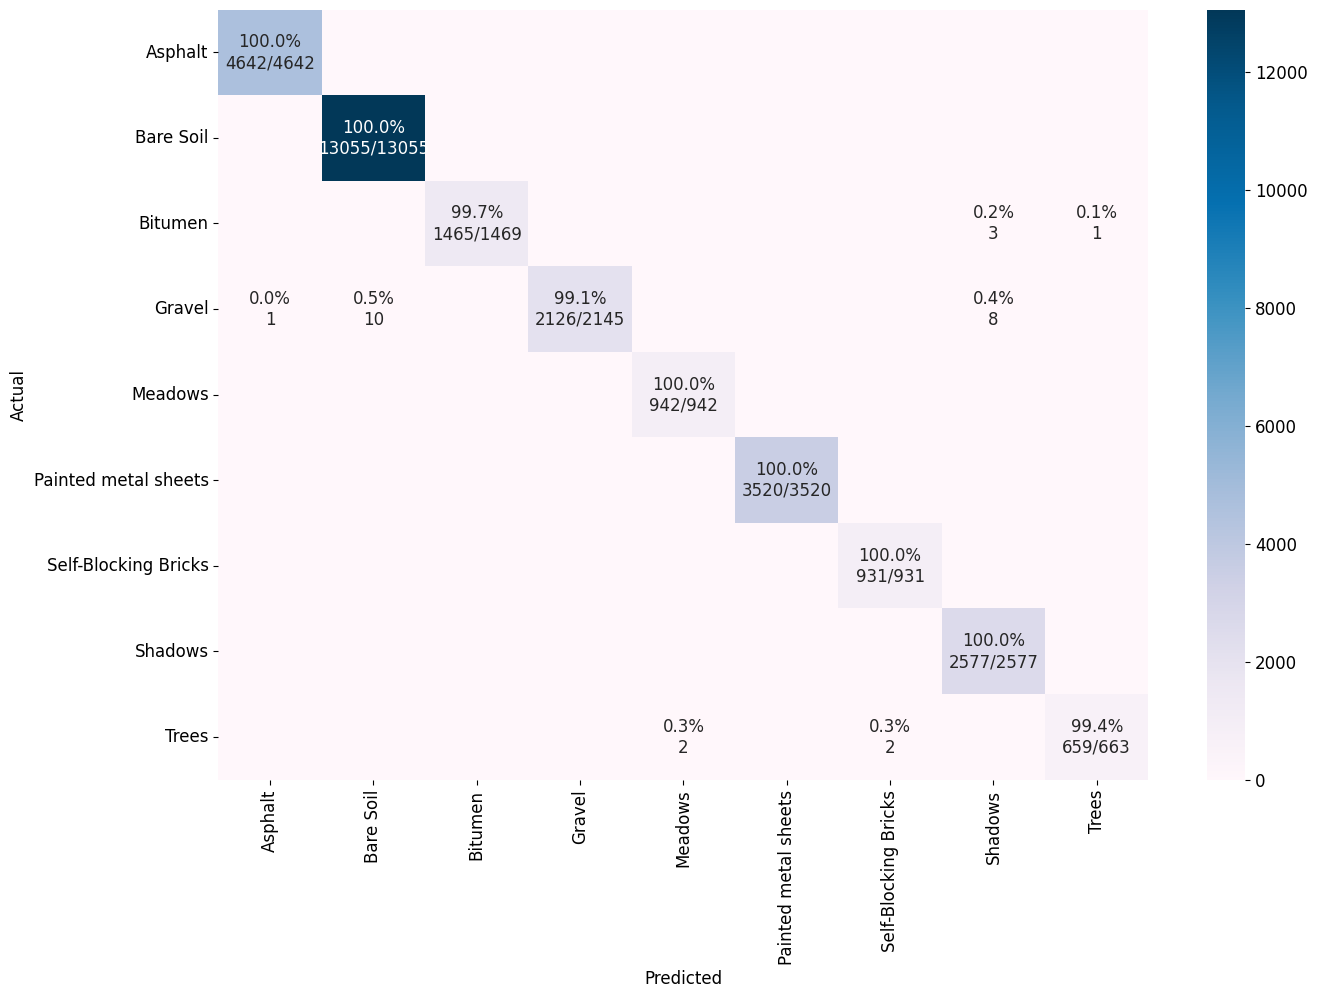

In [25]:
target_names = ['Asphalt','Meadows','Gravel','Trees', 'Painted metal sheets','Bare Soil','Bitumen',
                        'Self-Blocking Bricks','Shadows']
## Draw Confusion Matrix
confusion = confusion_matrix(np.argmax(ytest, axis=1), y_pred_test, labels=np.unique(np.argmax(ytest, axis=1)))
cm_sum = np.sum(confusion, axis=1, keepdims=True)
cm_perc = confusion / cm_sum.astype(float) * 100
annot = np.empty_like(confusion).astype(str)
nrows, ncols = confusion.shape
for i in range(nrows):
    for j in range(ncols):
        c = confusion[i, j]
        p = cm_perc[i, j]
        if i == j:
            s = cm_sum[i]
            annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
        elif c == 0:
            annot[i, j] = ''
        else:
            annot[i, j] = '%.1f%%\n%d' % (p, c)
cm = pd.DataFrame(confusion, index=np.unique(target_names), columns=np.unique(target_names))
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
fig, ax = plt.subplots(figsize=(15,10))
#plt.rcParams.update({'font.size': 12})
plt.rc('font',family='Lato Light',size=12)

sns.heatmap(cm, cmap="PuBu", annot=annot, fmt='', ax=ax)

In [26]:
def Patch(data,height_index,width_index):
    height_slice = slice(height_index, height_index+PATCH_SIZE)
    width_slice = slice(width_index, width_index+PATCH_SIZE)
    patch = data[height_slice, width_slice, :]

    return patch

# Show predicted image

## show

In [27]:
def Patch(data,height_index,width_index):
    height_slice = slice(height_index, height_index+PATCH_SIZE)
    width_slice = slice(width_index, width_index+PATCH_SIZE)
    patch = data[height_slice, width_slice, :]
    return patch

# K after PCA
K = 30
windowSize1 = 25


In [ ]:

X = sio.loadmat('/kaggle/input/dataset/dataset/PU/PaviaU.mat')['paviaU']
y = sio.loadmat('/kaggle/input/dataset/dataset/PU/PaviaU_gt.mat')['paviaU_gt']


height = y.shape[0]
width = y.shape[1]
PATCH_SIZE = windowSize1
numComponents = K

# X,pca = applyPCA(X, numComponents=numComponents)
X = applyPCA(X, numComponents= pca_components)
X = padWithZeros(X, PATCH_SIZE//2)

# calculate the predicted image
outputs = np.zeros((height,width))
for i in range(height):
    for j in range(width):
        target = int(y[i,j])
        if target == 0 :
            continue
        else :
            image_patch=Patch(X,i,j)
            X_test_image = image_patch.reshape(1,image_patch.shape[0],image_patch.shape[1], image_patch.shape[2], 1).astype('float32')
            prediction = (model.predict(X_test_image))
            prediction = np.argmax(prediction, axis=1)
            outputs[i][j] = prediction+1



1/1 [==============================] - 0s 34ms/step


/tmp/ipykernel_13/3550687592.py:26: DeprecationWarning:

Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)



1/1 [==============================] - 0s 52ms/step


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1/1 [==============================] - 0s 36ms/step


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1/1 [==============================] - 0s 35ms/step


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1/1 [==============================] - 0s 37ms/step


/usr/local/lib/python3.10/site-packages/spectral/graphics/spypylab.py:796: UserWarning:

Failed to create RectangleSelector object. Interactive pixel class labeling will be unavailable.

findfont: Font family 'Lato Light' not found.
findfont: Font family 'Lato Light' not found.
findfont: Font family 'Lato Light' not found.
findfont: Font family 'Lato Light' not found.
findfont: Font family 'Lato Light' not found.
findfont: Font family 'Lato Light' not found.
findfont: Font family 'Lato Light' not found.
findfont: Font family 'Lato Light' not found.
findfont: Font family 'Lato Light' not found.
findfont: Font family 'Lato Light' not found.
findfont: Font family 'Lato Light' not found.
findfont: Font family 'Lato Light' not found.
findfont: Font family 'Lato Light' not found.
findfont: Font family 'Lato Light' not found.
findfont: Font family 'Lato Light' not found.
findfont: Font family 'Lato Light' not found.
findfont: Font family 'Lato Light' not found.
findfont: Font family 'Lato Lig

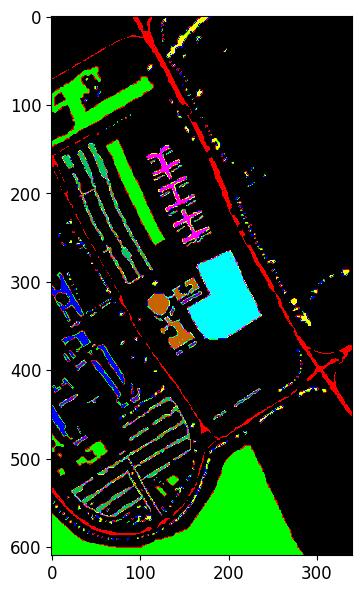

findfont: Font family 'Lato Light' not found.
findfont: Font family 'Lato Light' not found.
findfont: Font family 'Lato Light' not found.
findfont: Font family 'Lato Light' not found.
findfont: Font family 'Lato Light' not found.
findfont: Font family 'Lato Light' not found.
findfont: Font family 'Lato Light' not found.
findfont: Font family 'Lato Light' not found.
findfont: Font family 'Lato Light' not found.
findfont: Font family 'Lato Light' not found.
findfont: Font family 'Lato Light' not found.
findfont: Font family 'Lato Light' not found.
findfont: Font family 'Lato Light' not found.
findfont: Font family 'Lato Light' not found.
findfont: Font family 'Lato Light' not found.
findfont: Font family 'Lato Light' not found.
findfont: Font family 'Lato Light' not found.
findfont: Font family 'Lato Light' not found.
findfont: Font family 'Lato Light' not found.


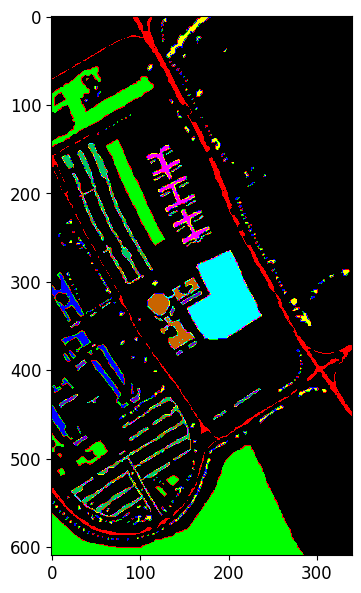

In [29]:
ground_truth = spectral.imshow(classes = y,figsize =(7,7))
predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(7,7))
spectral.save_rgb("predictions.jpg", outputs.astype(int), colors=spectral.spy_colors)
spectral.save_rgb("ground_truth.png", y, colors=spectral.spy_colors)